In [2]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))  # notebooks → code



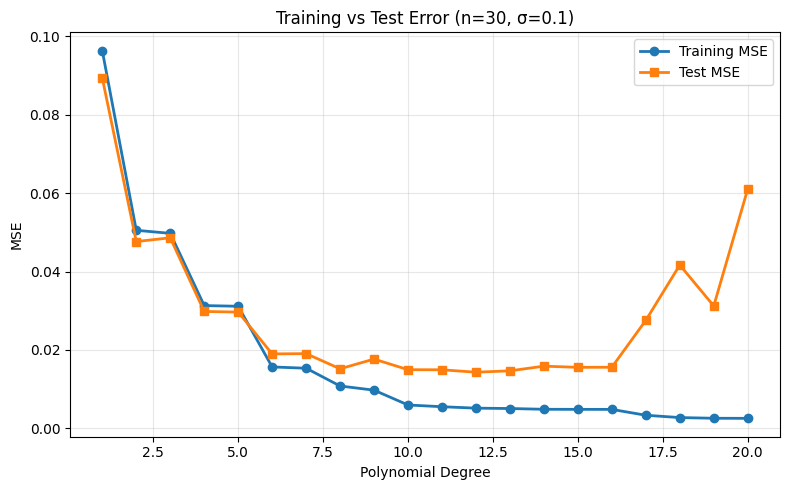

Optimal degree: 12


In [11]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.regression import ols_svd  # Use SVD instead

np.random.seed(314)

# -------------------
# Config
# -------------------
n = 30
sigma = 0.1
degrees = np.arange(1, 21)  # Stop before it explodes

# Training data
x_train = equispaced_points(n)
y_train = runge_function(x_train) + np.random.normal(0, sigma, size=n)

# Test data
n_test = 100
x_test = np.linspace(-1, 1, n_test)
y_test = runge_function(x_test) + np.random.normal(0, sigma, size=n_test)

# -------------------
# Compute train/test MSE
# -------------------
train_mse = []
test_mse = []

for d in degrees:
    X_train = vandermonde(x_train, d)
    X_test = vandermonde(x_test, d)
    
    coef, predict_fn, _ = ols_svd(X_train, y_train)  # SVD is stable
    
    train_mse.append(np.mean((y_train - predict_fn(X_train, coef))**2))
    test_mse.append(np.mean((y_test - predict_fn(X_test, coef))**2))

# -------------------
# Plot
# -------------------
plt.figure(figsize=(8, 5))
plt.plot(degrees, train_mse, 'o-', label='Training MSE', color='C0', linewidth=2)
plt.plot(degrees, test_mse, 's-', label='Test MSE', color='C1', linewidth=2)
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title(f'Training vs Test Error (n={n}, σ={sigma})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save
fig_dir = os.path.join('..', 'figures')
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, 'train_test_mse.pdf'))
plt.show()

print(f"Optimal degree: {degrees[np.argmin(test_mse)]}")

Computing bias-variance decomposition...


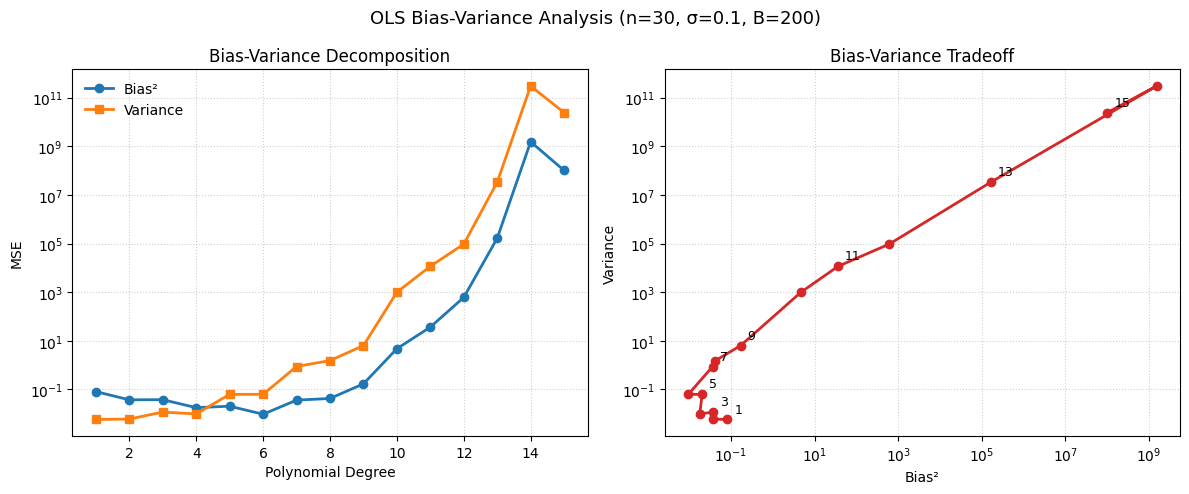


Optimal degree (min total error): 4
  Bias²: 0.017806
  Variance: 0.009809
  Total: 0.027615


In [14]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.regression import ols_svd
from src.bias_variance import compute_bias_variance

np.random.seed(314)

# -------------------
# Config
# -------------------
n = 30
sigma = 0.1
degrees = np.arange(1, 16)  # Stop at 15 to avoid instability
B = 200  # Bootstrap samples

x = equispaced_points(n)
y = runge_function(x) + np.random.normal(0, sigma, size=n)

x_grid = np.linspace(-1, 1, 400)
y_true = runge_function(x_grid)

# -------------------
# Compute bias-variance
# -------------------
print("Computing bias-variance decomposition...")
bias2, variance, total = compute_bias_variance(
    x, y, x_grid, y_true, degrees, ols_svd, trials=B, seed=314
)

# -------------------
# Plot
# -------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Components vs degree
ax = axes[0]
ax.semilogy(degrees, bias2, 'o-', label='Bias²', linewidth=2, color='C0')
ax.semilogy(degrees, variance, 's-', label='Variance', linewidth=2, color='C1')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('MSE')
ax.set_title('Bias-Variance Decomposition')
ax.legend(frameon=False)
ax.grid(True, which='both', linestyle=':', alpha=0.6)

# Right: Tradeoff
ax = axes[1]
ax.loglog(bias2, variance, 'o-', linewidth=2, color='C3')
for i, d in enumerate(degrees):
    if d % 2 == 1:  # Label odd degrees
        ax.annotate(str(d), (bias2[i], variance[i]), 
                   fontsize=9, xytext=(5, 5), textcoords='offset points')
ax.set_xlabel('Bias²')
ax.set_ylabel('Variance')
ax.set_title('Bias-Variance Tradeoff')
ax.grid(True, which='both', linestyle=':', alpha=0.6)

fig.suptitle(f'OLS Bias-Variance Analysis (n={n}, σ={sigma}, B={B})', 
             fontsize=13, y=0.98)
plt.tight_layout()

# -------------------
# Save
# -------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, 'ols_bias_variance_decomposition.pdf'), bbox_inches='tight')
plt.show()

print(f"\nOptimal degree (min total error): {degrees[np.argmin(total)]}")
print(f"  Bias²: {bias2[np.argmin(total)]:.6f}")
print(f"  Variance: {variance[np.argmin(total)]:.6f}")
print(f"  Total: {total[np.argmin(total)]:.6f}")